In [10]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dftest = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

In [11]:
dftrain.head(2)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n


In [12]:
y_train=dftrain.pop('survived')
y_test=dftest.pop('survived')

In [13]:
dftrain.head(2)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n


In [14]:
y_train.head(2)

0    0
1    1
Name: survived, dtype: int64

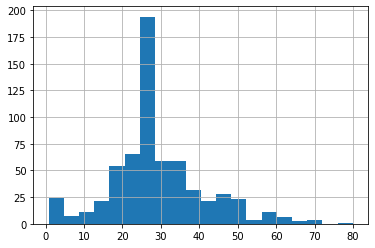

In [18]:
dftrain['age'].hist(bins=20)
plt.show()

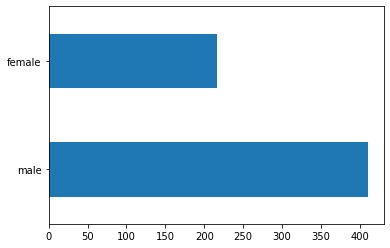

In [19]:
dftrain['sex'].value_counts().plot(kind='barh')
plt.show()

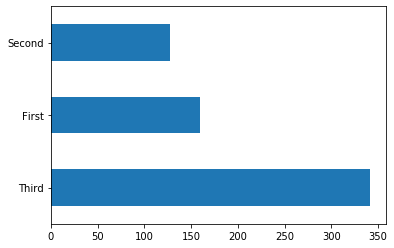

In [20]:
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

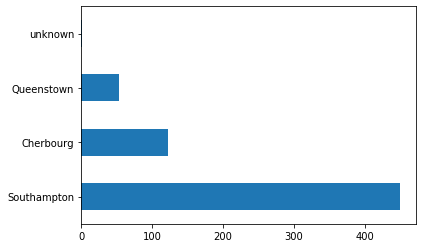

In [21]:
dftrain['embark_town'].value_counts().plot(kind='barh')

In [22]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean()

sex
female    0.778802
male      0.180488
Name: survived, dtype: float64

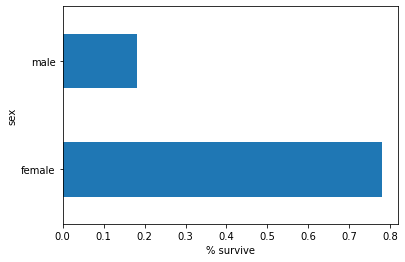

In [23]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.show()

In [40]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                     'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

In [41]:
import tensorflow as tf
feature_columns=[]
for feature_name in CATEGORICAL_COLUMNS:
    category_for_feature=dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name,category_for_feature))

In [42]:
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [31]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dftest, y_test, shuffle=False, n_epochs=1)

In [32]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.784091
accuracy_baseline         0.625000
auc                       0.840373
auc_precision_recall      0.791438
average_loss              0.459138
label/mean                0.375000
loss                    121.212433
precision                 0.723404
prediction/mean           0.375881
recall                    0.686869
global_step             100.000000
dtype: float64


In [33]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.825758
accuracy_baseline         0.625000
auc                       0.872360
auc_precision_recall      0.857325
average_loss              0.411853
label/mean                0.375000
loss                      0.411853
precision                 0.784946
prediction/mean           0.382282
recall                    0.737374
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/f2/sg5ytcdn36v_nrhp1b9q3m880000gn/T/tmpz056pn8e/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


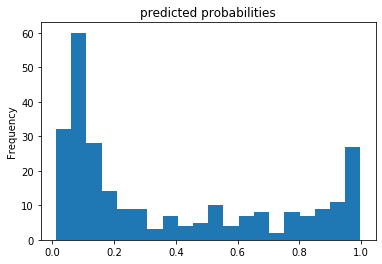

In [34]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

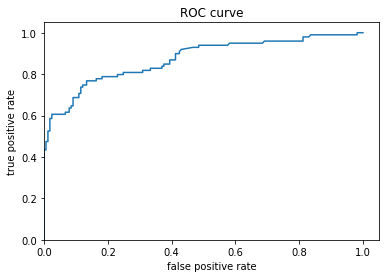

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [69]:

features = ['sex', 'parch', 'class','embark_town']
X = pd.get_dummies(dftrain[features])
X_test = pd.get_dummies(dftest[features])

print(X.shape)
print(X_test.shape)

(627, 10)
(264, 10)


In [71]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1).fit(X, y_train)

predictions = model.predict(X_test)



In [73]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[145  20]
 [ 38  61]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       165
           1       0.75      0.62      0.68        99

    accuracy                           0.78       264
   macro avg       0.77      0.75      0.76       264
weighted avg       0.78      0.78      0.78       264



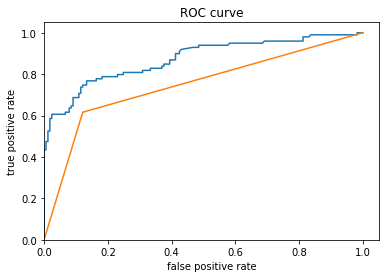

In [76]:
from sklearn.metrics import roc_curve

fpr2, tpr2, _ = roc_curve(y_test, predictions)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)

plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()